In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
wandb.login()

In [ ]:
wandb_default_config = {
    'BATCH_SIZE': 8,
    'NUM_EPOCHS': 50,
    'LEARNING_RATE': 0.05657808132757078,
    'WEIGHT_DECAY' = 1e-4}

In [ ]:
sweep_config = {
    'name': 'YOLO',
    'method': 'bayes',
    'metric': {
        'name': 'val_loss', 
        'goal': 'minimize' 
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 3
    },
    'parameters': {
        'BATCH_SIZE': {
            'values': [2, 8, 16, 32, 64]
        },
        'NUM_EPOCHS': {
            'values': [10, 25, 50, 100]
        },
        'LEARNING_RATE': {
            'min': 0.001,
            'max': 0.1
        },
        'WEIGHT_DECAY': {
            'min': 0.01,
            'max': 0.0001
        }, 
    }
}

pprint(sweep_config)

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="crypto_predictions",
    # track hyperparameters and run metadata
    config=default_config
)

sweep_id = wandb.sweep(sweep_config)

In [2]:
config1 = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["B", 8],
    # second route from the end of the previous block
    (1024, 3, 2),
    ["B", 4],
    # until here is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + self.use_residual * x

        return x

In [5]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes): #anchors_per_scale
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes
        self.anchors_per_scale = 3 #anchors_per_scale

    def forward(self, x):
        return (
            self.pred(x)
                .reshape(x.shape[0], self.anchors_per_scale, self.num_classes + 5, x.shape[2], x.shape[3])
                .permute(0, 1, 3, 4, 2)
        )

In [6]:
print(config1)

[(32, 3, 1), (64, 3, 2), ['B', 1], (128, 3, 2), ['B', 2], (256, 3, 2), ['B', 8], (512, 3, 2), ['B', 8], (1024, 3, 2), ['B', 4], (512, 1, 1), (1024, 3, 1), 'S', (256, 1, 1), 'U', (256, 1, 1), (512, 3, 1), 'S', (128, 1, 1), 'U', (128, 1, 1), (256, 3, 1), 'S']


In [7]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config1:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(
                    ResidualBlock(
                        in_channels,
                        num_repeats=num_repeats,
                    )
                )

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(
                        nn.Upsample(scale_factor=2),
                    )
                    in_channels = in_channels * 3

        return layers

In [8]:
def test():
    num_classes = 4#20
    img_size = 416
    model = YOLOv3(num_classes=num_classes)

    x = torch.randn((2, 3, img_size, img_size))
    out = model(x)
    assert out[0].shape == (2, 3, img_size//32, img_size//32, 5 + num_classes)
    assert out[1].shape == (2, 3, img_size//16, img_size//16, 5 + num_classes)
    assert out[2].shape == (2, 3, img_size//8, img_size//8, 5 + num_classes)

test()

# Loss

In [9]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn

# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/kaggle/input/source')
#import file
import utils


class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        """
        :param predictions: output from model of shape: (batch size, anchors on scale , grid size, grid size, 5 + num classes)
        :param target: targets on particular scale of shape: (batch size, anchors on scale, grid size, grid size, 6)
        :param anchors: anchor boxes on the particular scale of shape (anchors on scale, 2)
        :return: returns the loss on the particular scale
        """

        # Check where obj and noobj (we ignore if target == -1)
        # Here we check where in the label matrix there is an object or not
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # The indexing noobj refers to the fact that we only apply the loss where there is no object
        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )

        # Here we compute the loss for the cells and anchor boxes that contain an object
        # Reschape anchors to allow for broadcasting in multiplication below
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        # Convert outputs from model to bounding boxes according to formulas in paper
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        # Targets for the object prediction should be the iou of the predicted bounding box and the target bounding box
        ious = utils.intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        # Only incur loss for the cells where there is an objects signified by indexing with obj
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

        # apply sigmoid to x, y coordinates to convert to bounding boxes
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])
        # to improve gradient flow we convert targets' width and height to the same format as predictions
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )
        # compute mse loss for boxes
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # here we just apply cross entropy loss as is customary with classification problems
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [10]:
#import config
import numpy as np
import os
import pandas as pd
import torch

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from utils import (
    cells_to_bboxes, # only for testing
    iou_width_height as iou,
    non_max_suppression as nms, # only for testing
    plot_image #only for testing
)

ImageFile.LOAD_TRUNCATED_IMAGES = True # na errory pri loadovani img

In [11]:
import matplotlib.pyplot as plt

In [12]:
def check_bbox(bboxes):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
    #my added block 
    #bbox=list(bbox)
    for bbox in bboxes:
      print(bbox)
      for i in range(1):
        if (bbox[i]<0) :
              print(True)
        #  bbox[i]=0
        #elif (bbox[i]>1) :
        #  bbox[i]=1
        print((((bbox[3] + bbox[i]) / 2) / 416) < 0)
      #bbox=tuple(bbox)
   #end of block
   #rest of the code as it is

In [13]:
class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=4,#20,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))
        #print(index, img_path, bboxes)
        #check_bbox(bboxes)
        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            #print("YoloDataset x,y: ",x, y)
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    #print(x_cell, y_cell)
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    #check_bbox(box_coordinates)
                    #print([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction
        #print(targets)
        return image, tuple(targets)


Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  0


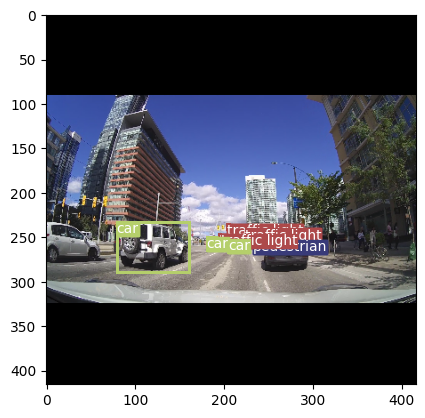

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  1


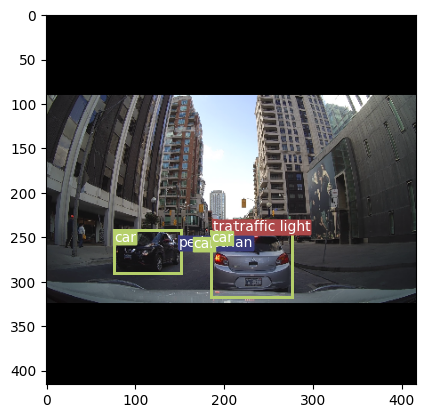

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  2


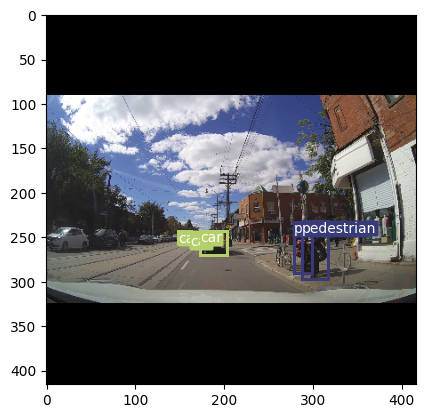

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  3


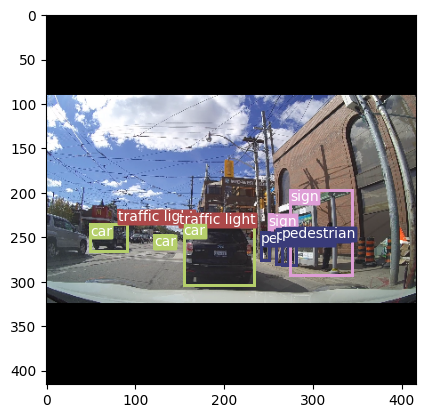

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  4


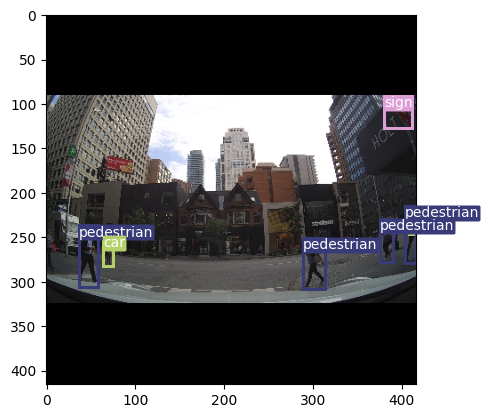

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  5


In [14]:
import config
from pprint import pprint
def test():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        '/kaggle/input/mapping/train.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',#config.LABEL_DIR,
        S=config.S,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    #print(" : ",dataset.transform," : ")
    S = config.S #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    counter = 0
    for x, y in loader:
        #print("x,y: ",x,y)
        #print("A ",loader.__annotations__["dataset"])
        # pom1 = loader.sampler.data_source.annotations.values[72]
        # pom2 = loader.sampler.data_source.annotations.values[73]
        # pom3 = loader.sampler.data_source.annotations.values[74]
        # print("ADS ",pom1,pom2,pom3)
        boxes = []
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print("Shape of anchor: ",anchor.shape)
            print("Loader y: ",y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print("Counter> ",counter)
        counter +=1
        if counter>5:
            break
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        #print("BOXES: ",boxes)
        #pprint(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
        #plot_image(x[0].to("cpu"),boxes)


# if __name__ == "__main__":
test()

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  0


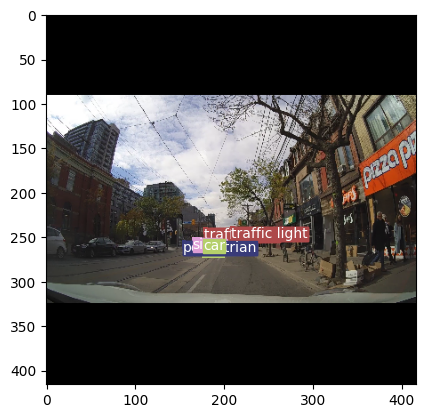

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  1


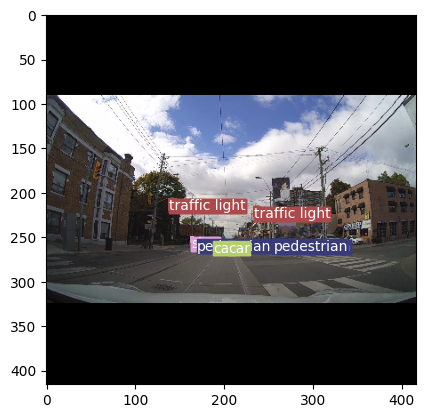

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  2


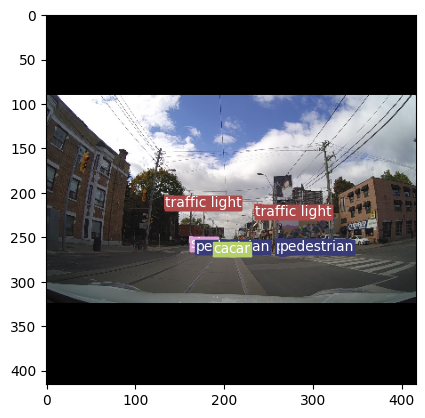

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  3


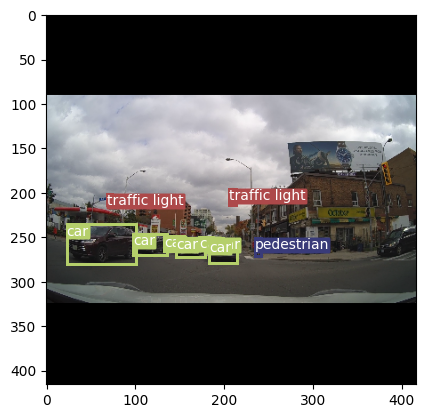

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  4


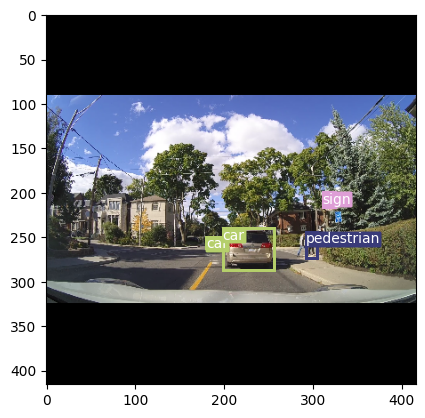

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  5


In [15]:
import config
from pprint import pprint
def test():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        S=config.S,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    #print(" : ",dataset.transform," : ")
    S = config.S #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    counter = 0
    for x, y in loader:
        #print("x,y: ",x,y)
        #print("A ",loader.__annotations__["dataset"])
        # pom1 = loader.sampler.data_source.annotations.values[72]
        # pom2 = loader.sampler.data_source.annotations.values[73]
        # pom3 = loader.sampler.data_source.annotations.values[74]
        # print("ADS ",pom1,pom2,pom3)
        boxes = []
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print("Shape of anchor: ",anchor.shape)
            print("Loader y: ",y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print("Counter> ",counter)
        counter +=1
        if counter>5:
            break
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        #print("BOXES: ",boxes)
        #pprint(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
        #plot_image(x[0].to("cpu"),boxes)


# if __name__ == "__main__":
test()

# Training

In [16]:
import gc
#def report_gpu():
#print(torch.cuda.list_gpu_processes())
gc.collect()


5077

In [17]:
torch.cuda.empty_cache()

In [18]:
gc.collect()

0

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
def accuracy_fn(y_true, y_pred):
    """
    Calculate equality of two tensors.
    :param y_true: real output
    :param y_pred: predictions
    :returns correctness
    """
    correct = torch.eq(y_true, y_pred).sum().item() 
    return correct

def check_class_accuracy(y, y_hat, threshold=0.6):
    #model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    #for idx, (x, y) in enumerate(loader):
    #    if idx == 100:
    #        break
    #    x = x.float()
    #    x = x.to(config.DEVICE)
        #with torch.no_grad():
            #print(x.shape)
        #    out = model(x)
    for i in range(3):
        y[i] = y[i].to(config.DEVICE)
        obj = y[i][..., 0] == 1 # in paper this is Iobj_i
        noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

        correct_class += torch.sum(
            torch.argmax(y_hat[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
        )
        tot_class_preds += torch.sum(obj)

        obj_preds = torch.sigmoid(y_hat[i][..., 0]) > threshold
        correct_obj += accuracy_fn(y[i][..., 0][obj], obj_preds[obj]) #torch.sum(obj_preds[obj] == y[i][..., 0][obj])
        tot_obj += torch.sum(obj)
        correct_noobj += accuracy_fn(y[i][..., 0][noobj], obj_preds[noobj])#torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
        tot_noobj += torch.sum(noobj)

    #model.train()
    
    return correct_class, tot_class_preds, correct_noobj, tot_noobj, correct_obj, tot_obj

In [21]:
def test_fn(loader, model, optimizer, scaled_anchors):
    """
    Evaulation
    """    
    #loop = tqdm(train_loader, leave=True)
    #print("A> ", enumerate(loop), " AHOJSTE",loop," <B")
    losses = []
    batches_counter = 0
    counter = 0

    # init epoch train counters
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    
    # disable gradient calculation
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader): #enumerate(loop):
            x = x.float()
            x = x.to(config.DEVICE)
            y0, y1, y2 = (
                y[0].to(config.DEVICE),
                y[1].to(config.DEVICE),
                y[2].to(config.DEVICE),
            )

            y_hat = model(x)

            correct_class_, tot_class_preds_, correct_noobj_, tot_noobj_, \
                correct_obj_, tot_obj_ = check_class_accuracy(y, y_hat, config.CONF_THRESHOLD)
            #print(correct_class_)
            
            correct_class += correct_class_
            tot_class_preds += tot_class_preds_
            correct_noobj += correct_noobj_
            tot_noobj += tot_noobj_
            correct_obj += correct_obj_
            tot_obj += tot_obj_
            
            batches_counter+=1
            
            if counter < 19:
                counter += 1
                if batches_counter % 16 == 0:
                    boxes = []
                    for i in range(y[0].shape[1]):
                        anchor = scaled_anchors[i]
                        print("Shape of anchor: ",anchor.shape)
                        print("Loader y: ",y[i].shape)
                        boxes += cells_to_bboxes(
                            y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
                        )[0]
                    boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
                    #print("BOXES: ",boxes)
                    #pprint(boxes)
                    plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


    class_acc = (correct_class/(tot_class_preds+1e-16))*100
    no_obj_acc = (correct_noobj/(tot_noobj+1e-16))*100
    obj_acc = (correct_obj/(tot_obj+1e-16))*100
    
    pred_boxes, true_boxes = get_evaluation_bboxes(
        loader,
        model,
        iou_threshold=config.NMS_IOU_THRESH,
        anchors=config.ANCHORS,
        threshold=config.CONF_THRESHOLD,
    )
    mapval = mean_average_precision(
        pred_boxes,
        true_boxes,
        iou_threshold=config.MAP_IOU_THRESH,
        box_format="midpoint", #midpoint originally
        num_classes=config.NUM_CLASSES,
    )
    
    return class_acc, no_obj_acc, obj_acc, mapval

In [22]:
def val_fn(loader, model, optimizer, loss_fn, scaled_anchors):
    """
    Validation
    """    
    #loop = tqdm(train_loader, leave=True)
    #print("A> ", enumerate(loop), " AHOJSTE",loop," <B")
    losses = []
    batches_counter = 0

    # init epoch train counters
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    
    # disable gradient calculation
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader): #enumerate(loop):
            x = x.float()
            x = x.to(config.DEVICE)
            y0, y1, y2 = (
                y[0].to(config.DEVICE),
                y[1].to(config.DEVICE),
                y[2].to(config.DEVICE),
            )

            y_hat = model(x)
            loss = (
                loss_fn(y_hat[0], y0, scaled_anchors[0])
                + loss_fn(y_hat[1], y1, scaled_anchors[1])
                + loss_fn(y_hat[2], y2, scaled_anchors[2])
            )

            losses.append(loss.item())

            correct_class_, tot_class_preds_, correct_noobj_, tot_noobj_, \
                correct_obj_, tot_obj_ = check_class_accuracy(y, y_hat, config.CONF_THRESHOLD)
            
            correct_class += correct_class_
            tot_class_preds += tot_class_preds_
            correct_noobj += correct_noobj_
            tot_noobj += tot_noobj_
            correct_obj += correct_obj_
            tot_obj += tot_obj_
            
            batches_counter+=1

    mean_loss = sum(losses) / len(losses)
    class_acc = (correct_class/(tot_class_preds+1e-16))*100
    no_obj_acc = (correct_noobj/(tot_noobj+1e-16))*100
    obj_acc = (correct_obj/(tot_obj+1e-16))*100
    
    return mean_loss, class_acc, no_obj_acc, obj_acc

Currently epoch 0
Train loss: 13.644215
Train Class accuracy is: 83.795479%
Train No obj accuracy is: 99.390717%
Train Obj accuracy is: 1.380601%
=> Saving checkpoint
Val loss: 18.897531
Val Class accuracy is: 66.243706%
Val No obj accuracy is: 99.999466%
Val Obj accuracy is: 0.364618%
Currently epoch 1
Train loss: 4.651614
Train Class accuracy is: 99.207321%
Train No obj accuracy is: 99.985703%
Train Obj accuracy is: 22.844273%
=> Saving checkpoint
Val loss: 17.302098
Val Class accuracy is: 70.006561%
Val No obj accuracy is: 99.992569%
Val Obj accuracy is: 0.619850%
Currently epoch 2
Train loss: 3.125561
Train Class accuracy is: 99.900551%
Train No obj accuracy is: 99.950638%
Train Obj accuracy is: 52.527203%
=> Saving checkpoint
Val loss: 17.334777
Val Class accuracy is: 70.254501%
Val No obj accuracy is: 99.995255%
Val Obj accuracy is: 0.182309%
Currently epoch 3
Train loss: 2.526958
Train Class accuracy is: 99.959053%
Train No obj accuracy is: 99.945427%
Train Obj accuracy is: 68.1

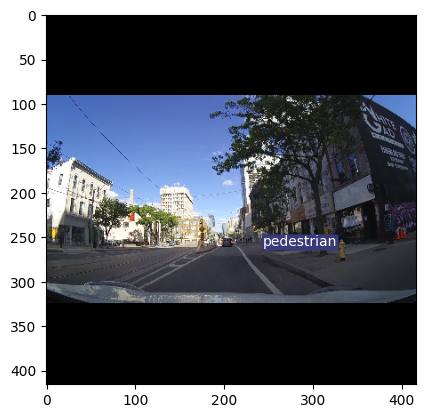

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])


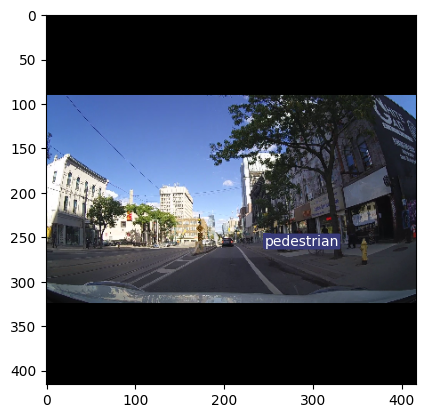

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])


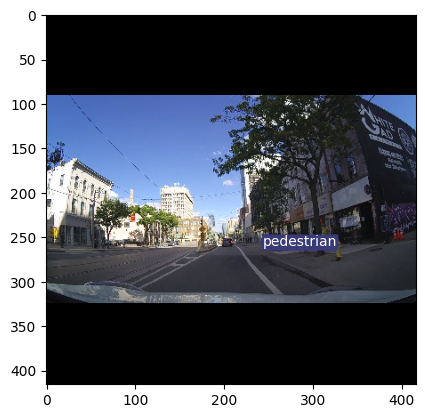

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])


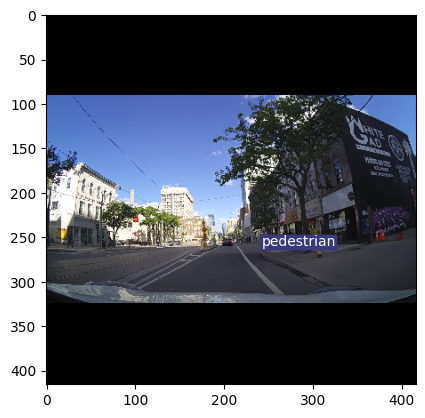

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])


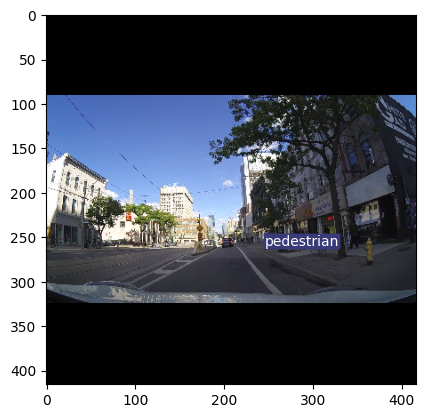

100%|██████████| 700/700 [02:51<00:00,  4.09it/s]


Test Class accuracy is: 69.601532%
Test No obj accuracy is: 99.999527%
Test Obj accuracy is: 0.000000%
MAP: 0.0


In [23]:
"""
Main file for training Yolo model on Pascal VOC and COCO dataset
"""

import config
import torch
import torch.optim as optim
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    #check_class_accuracy,
    plot_couple_examples
)

torch.backends.cudnn.benchmark = True


def train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors): # scaler
    """
    Training
    """    
    #loop = tqdm(train_loader, leave=True)
    #print("A> ", enumerate(loop), " AHOJSTE",loop," <B")
    losses = []
    batches_counter = 0

    # init epoch train counters
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    
    for batch_idx, (x, y) in enumerate(train_loader): #enumerate(loop):
    #for x,y in train_loader:
        #print("x,y",x,y)
        #print(batch_idx," <x> ",x," <y> ",y, " <>L")
        x = x.float()
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
        
        # clear the gradients
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            y_hat = model(x)
            loss = (
                loss_fn(y_hat[0], y0, scaled_anchors[0])
                + loss_fn(y_hat[1], y1, scaled_anchors[1])
                + loss_fn(y_hat[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        loss.backward()
        optimizer.step()
        
        # update train counters
        #epoch_train_loss += loss.item()

        #epoch_train_true_action += accuracy_fn(y_action_, y_batch_action)
        #epoch_train_total_action += len(y)
        
        correct_class_, tot_class_preds_, correct_noobj_, tot_noobj_, \
            correct_obj_, tot_obj_ = check_class_accuracy(y, y_hat, config.CONF_THRESHOLD)
        
        correct_class += correct_class_
        tot_class_preds += tot_class_preds_
        correct_noobj += correct_noobj_
        tot_noobj += tot_noobj_
        correct_obj += correct_obj_
        tot_obj += tot_obj_
        
        # class_acc, no_obj_acc, obj_acc
        #loop.set_postfix(loss=mean_loss)
        #print('loss', mean_loss)
        #print(batches_counter)
        batches_counter+=1
    
    mean_loss = sum(losses) / len(losses)
    class_acc = (correct_class/(tot_class_preds+1e-16))*100
    no_obj_acc = (correct_noobj/(tot_noobj+1e-16))*100
    obj_acc = (correct_obj/(tot_obj+1e-16))*100
    
    return mean_loss, class_acc, no_obj_acc, obj_acc


def main():
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="YOLO",
        # track hyperparameters and run metadata
        config=wandb_default_config
    )

    wandb_config = wandb.config
    
    model = YOLOv3(num_classes=wandb_config.NUM_CLASSES).to(config.DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=wandb_config.LEARNING_RATE, weight_decay=wandb_config.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    #scaler = torch.cuda.amp.GradScaler()

    # train_loader, test_loader, train_eval_loader = get_loaders(
    #     train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/train.csv"
    # )

    train_dataset = YOLODataset(
        '/kaggle/input/mapping/train.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        transform=config.test_transforms,
        S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=wandb_config.BATCH_SIZE,
        #num_workers=0,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    val_dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',#'../test.csv',
        transform=config.test_transforms,
        S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=wandb_config.BATCH_SIZE,
        #num_workers=0,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    
    test_dataset = YOLODataset(
        '/kaggle/input/mapping/test.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        S=[config.IMAGE_SIZE // 32, config.IMAGE_SIZE // 16, config.IMAGE_SIZE // 8],
        anchors=config.ANCHORS,
        transform=config.test_transforms,
    )

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=wandb_config.BATCH_SIZE,
                             pin_memory=config.PIN_MEMORY,
                             shuffle=False,
                             drop_last=False,)

    # if config.LOAD_MODEL:
    #     load_checkpoint(
    #         config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    #     )

    scaled_anchors = (
        torch.tensor(config.ANCHORS)
        * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(config.DEVICE)
    epoch_counter = 0
    
    # init train lists for statistics
    loss_train, class_acc_train, no_obj_acc_train, \
        obj_acc_train = list(), list(), list(), list()

    # init validation lists for statistics
    loss_val, class_acc_val, no_obj_acc_val, \
        obj_acc_val = list(), list(), list(), list()
    
    # early stopper
    early_stopper = EarlyStopper(patience=3, min_delta=1)
    for epoch in range(wandb_config.NUM_EPOCHS):
        # init epoch train counters
        epoch_train_acc, epoch_train_total, \
            epoch_train_true, epoch_train_loss = 0, 0, 0, 0
        
        #print(epoch_counter)
        print(f"Currently epoch {epoch}")
        #plot_couple_examples(model, train_loader, 0.6, 0.5, scaled_anchors)
        #train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
        
        mean_loss, class_acc, no_obj_acc, obj_acc = \
            train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors)
        
        print(f"Train loss: {mean_loss:2f}")
        print(f"Train Class accuracy is: {class_acc:2f}%")
        print(f"Train No obj accuracy is: {no_obj_acc:2f}%")
        print(f"Train Obj accuracy is: {obj_acc:2f}%")
        
        loss_train.append(mean_loss)
        class_acc_train.append(class_acc)
        no_obj_acc_train.append(no_obj_acc)
        obj_acc_train.append(obj_acc)
        
        if config.SAVE_MODEL:
            save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        # validation
        mean_loss, class_acc, no_obj_acc, obj_acc = \
            val_fn(val_loader, model, optimizer, loss_fn, scaled_anchors)
        
        print(f"Val loss: {mean_loss:2f}")
        print(f"Val Class accuracy is: {class_acc:2f}%")
        print(f"Val No obj accuracy is: {no_obj_acc:2f}%")
        print(f"Val Obj accuracy is: {obj_acc:2f}%")
        
        loss_val.append(mean_loss)
        class_acc_val.append(class_acc)
        no_obj_acc_val.append(no_obj_acc)
        obj_acc_val.append(obj_acc)
        
        # log metrics to WandB
        wandb.log({"train loss": loss_train[-1], 
                  "val_loss": loss_val[-1],
                  "train class accuracy": class_acc_train[-1],
                  "validation class accuracy": class_acc_val[-1],
                  "train no obj accuracy": no_obj_acc_train[-1],
                  "validation no obj accuracy": no_obj_acc_val[-1],
                  "train obj accuracy": obj_acc_train[-1],
                  "validation obj accuracy": obj_acc_val[-1]
                  })

        
        epoch_counter+=1
        
        # early stopping
        if early_stopper.early_stop(mean_loss):    
            print(f'Early stopped at {epoch_counter - 1}')         
            break
        
    #class_acc, no_obj_acc, obj_acc, mapval = \
    #        test_fn(test_loader, model, optimizer, scaled_anchors)
    
    #print(f"Test Class accuracy is: {class_acc:2f}%")
    #print(f"Test No obj accuracy is: {no_obj_acc:2f}%")
    #print(f"Test Obj accuracy is: {obj_acc:2f}%")
    #print(f"MAP: {mapval.item()}")

#main()

In [ ]:
#wandb.agent(sweep_id, function=main, count=10, project='YOLO')

In [ ]:
wandb.finish()

In [ ]:
api = wandb.Api()
sweep = api.sweep("xmatovice/YOLO/sweeps/" + sweep_id)

best_run = sweep.best_run()
print(best_run.id)
pprint(best_run.config)

In [24]:
#os.remove("/kaggle/input/source/utils.py")